# Convex Optimization : HW 3

**Author: KERROUMI Mohamed**


**1. The dual of Lasso**

Let us consider the LASSO problem

$$\text{minimize} \frac{1}{2}\|Xw-y\|_2^2+ \lambda \|w\|_1 $$
where $w\in \mathbf R^d,X\in\mathbf R^{n\times d},y\in\mathbf R^n$ and $\lambda>0$ the regularization parameter.

We rewrite the problem as:
\begin{alignat}{2}
&  \text{minimize}   &            &    \frac{1}{2} \|z\|_2^2+ \lambda \|w\|_1 && \\
&\text{subject to} & \qquad     &             Xw-y = z& \\
\end{alignat}

We consider the Lagrange multiplier $v$, the lagrangian is:
\begin{split}
L(z,w,v)&=\frac{1}{2}\|z\|_2^2+\lambda\|w\|_1+v^T(z+y-Xw)\\
&=\frac{1}{2}\|z\|_2^2+v^T(z+y) - \lambda f^*(\frac{v^T X }{\lambda})
\end{split}
With $f^*$ is the conjugate of $\|x\|_1$ and in the exercice 2 of HW2, we found that: 
$$f^*(x) = \left\{\begin{aligned} &0 &&\textrm{if $ -1\le x \le 1$}\\&+ \infty &&\textrm{otherwise }\end{aligned}\right.$$
So we have conditions on v:
$$ -\lambda \le v^T X \le \lambda$$
And we find that :
$$\inf_w L(z,w,v) = \frac{1}{2}\|z\|_2^2+v^T(z+y) $$
After derivation of the gradient we find that :
$$ g(v)= \inf_{w,z} L(z,w,v) = -\frac{1}{2} \|v\|^2 + v^Ty $$
Hence the dual problem of Lasso is:
\begin{alignat}{2}
&  \text{minimize}   &            &    \frac{1}{2} \|v\|_2^2- v^T y && \\
&\text{subject to} & \qquad     &        -\lambda \le v^T X \le \lambda     & \\
\end{alignat}
We format it as a general Quadratic Problem as follows: 

\begin{aligned}
& {\text{minimize}} & & v^TQv+p^Tv\\
& \text{subject to} & & Av\preceq b
\end{aligned}

Where $Q= \frac{1}{2} I_n \quad$ , $p=-y \quad$, $b=\lambda\quad$ and  $A=\begin{pmatrix} X^T\\ -X^T \end{pmatrix}$

**Question 2**

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
def loss(v,Q,p):
  return( np.dot(v.T, np.dot(Q,v))   +  np.dot(p.T , v)  )

def bar(x):
  return(- np.sum(np.log(x)) if np.all(x > 0) else np.inf)

def gradbar(x):
  return(-1/x)

def hessbar(x):
  return(np.diag(1/x[:,0]**2))

def phi(v,t,Q,p,A,b):
  return( np.dot(v.T, np.dot(Q,v))   +  np.dot(p.T , v)  +  (1/t) * bar(b - np.dot(A,v)))

def grad(v,t,Q,p,A,b):
  return( np.dot(Q,v) + p -(1/t) * np.dot( A.T , gradbar( b - np.dot(A, v))))

def hess(v,t,Q,p,A,b):

  return(Q + (1/t) * np.dot( A.T, np.dot( hessbar(b - np.dot(A, v)), A)))
def centering_step(Q, p, A, b, t , v0, eps):
  beta=0.7
  alpha=0.1
  v= v0
  lambda2= np.inf
  max_iter=20
  iter=1
  while lambda2/2 > eps and iter < max_iter:
    dv= -np.dot( np.linalg.pinv(hess(v, t, Q, p, A , b)), grad(v,t,Q,p,A,b))
    lamda2= - grad(v,t,Q,p,A,b).T * dv
    t1= 1 
    while phi(v + t1* dv ,t,Q,p,A,b ) > (phi(v,t,Q,p,A,b ) + alpha* t1* np.dot(grad(v, t,Q,p,A,b).T , dv)):
      t1 = t1* beta
    v = v + t1 * dv
    iter +=1
  return(v)

def barr_method(Q, p , A, b, v0, eps , mu=20):
  m = np.shape(A)[0]
  t=1
  v = v0
  solution =[v0]
  his_loss= [loss(v,Q,p)[0][0]]
  DGap=[m/t]
  while m/t > eps:
    v= centering_step(Q,p, A, b,t, v, eps)
    t = mu * t
    solution.append(v)
    his_loss.append(loss(v,Q,p)[0,0])
    DGap.append(m/t)
  n_iter= len(solution)
  his_loss= np.array(his_loss)
  return(v, solution, his_loss, DGap, n_iter)



**Question 3**

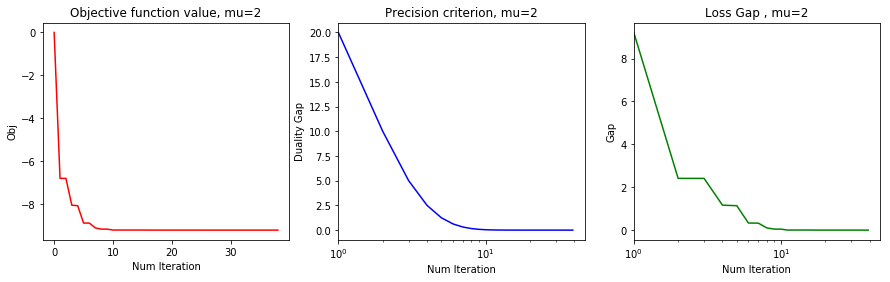

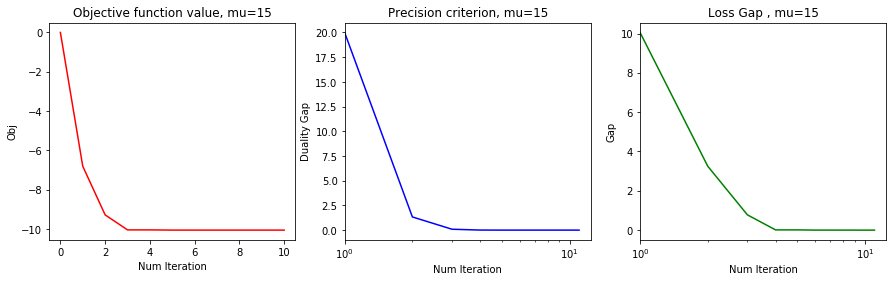

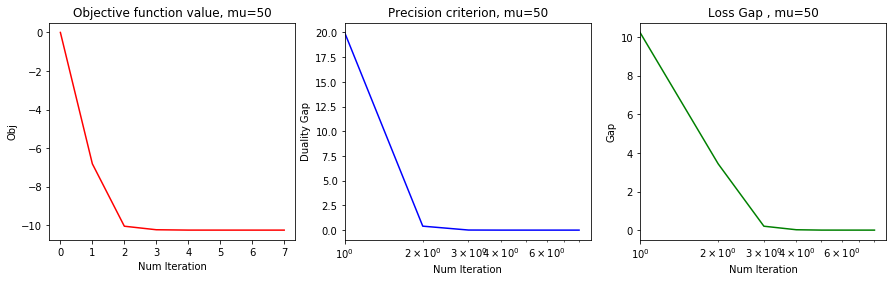

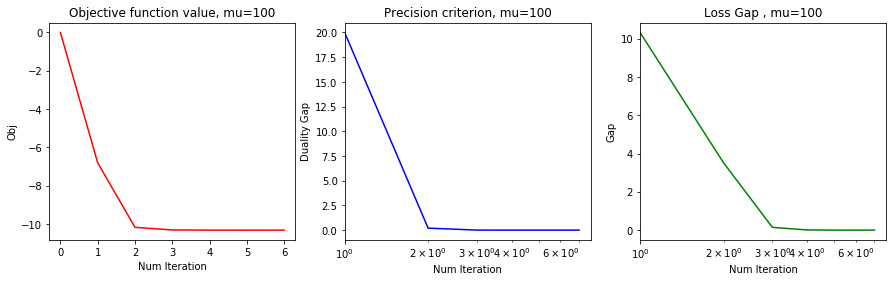

In [5]:
lambda1=10
eps=1e-10
n=100
d=10
#Random sample
X=np.random.rand(n,d)
y=np.random.rand(n,1)
#Define matrix Q,p,A,b
Q= 0.5 * np.identity(n)
p=-y
A= np.vstack((X.T, -X.T))
b= lambda1 * np.ones((2*d,1))
# initialize with a zers vector because it's a feasible solution:
v0=np.zeros((n,1))

mu=[2,15,50,100]

for i in range(len(mu)):
  (v, solution, his_loss,DGap, n_iter)= barr_method(Q, p, A, b, v0, eps, mu=mu[i])
  plt.figure(figsize=(15, 4))
  plt.subplot(1,3,1)
  plt.plot(range(n_iter), his_loss, 'red' )
  plt.xlabel("Num Iteration")
  plt.ylabel("Obj")
  plt.title("Objective function value, mu=" +str(mu[i]))
  plt.subplot(1,3,2)
  plt.plot(range(1,n_iter+1), DGap, 'blue')
  plt.xscale('log')
  plt.xlabel("Num Iteration")
  plt.ylabel("Duality Gap")
  plt.xlim(1)
  plt.title("Precision criterion, mu="+str(mu[i]))
  plt.subplot(1,3,3)
  plt.plot(range(1,n_iter+1),his_loss-his_loss[-1] , 'green')
  plt.xscale('log')
  plt.xlabel("Num Iteration")
  plt.ylabel("Gap")
  plt.xlim(1)
  plt.title("Loss Gap , mu="+str(mu[i]))
  plt.show()




Among the tested values of $\mu\in \{2,12,50,100\}$ the most appropriate one is 100, it requires the smallest number of iterations to converge. 